In [1]:
from r3d2 import State, eos_defns
import numpy
numpy.seterr(invalid='raise')
from scipy.optimize import brentq
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 8)
plt.rc("font", size=25)

In [2]:
gamma = 5/3
eos = eos_defns.eos_gamma_law(gamma)
# rho, v, vt, eps, eos
q_right = State(8.0, -0.2, 0, 2.5, eos)

rhoL = 5.0
vL = 0.0
epsL = 2.0

In [21]:
# TODO: refactor this so use q_L rather than all the other _L quantities
# TODO: check this using the solver to see if it really does give the correct vt_crit
# TODO: this only works in the shock region. See if can extend it to the rarefaction region too?
def find_crit_vt(vt_L, q_R, rho_L, v_L, eps_L, eos, lr_sign=-1):
    # FIXME: this isn't quite correct as rho_L* != rho_R*, h_L* != h_R*
    """
    Returns vx_L* - vx_R, which should be 0 at the tangential velocity.
    """
    
    p_L = eos['p_from_rho_eps'](rho_L, eps_L)
    h_L = eos['h_from_rho_eps'](rho_L, eps_L)
    
    def find_eps_star(eps_star):
        rho_star = eos['rho_from_p_eps'](q_R.p, eps_star)
        h_star = eos['h_from_rho_eps'](rho_star, eps_star)
        
        return h_star**2 - h_L**2 - (h_star/rho_star + h_L/rho_L) * (q_R.p - p_L)
     
        
    eps_min = min(q_R.eps, eps_L) * 0.9
    eps_max = max(q_R.eps, eps_L) * 1.1
    
    max_iter = 1000
    i = 0
    
    while find_eps_star(eps_min) * find_eps_star(eps_max) > 0.0 and i < max_iter:
        i += 1
        eps_min /= 5.0
        eps_max *= 5.0
        
    #print('find_eps_star(eps_min) * find_eps_star(eps_max) = {}'.format(find_eps_star(eps_min) * find_eps_star(eps_max)))
        
    if find_eps_star(eps_min) * find_eps_star(eps_max) > 0.0:
        raise StopIteration('Reached max_iter')
    
    eps_star = brentq(find_eps_star, eps_min, eps_max)
    
    rho_star = eos['rho_from_p_eps'](q_R.p, eps_star)
    h_star = eos['h_from_rho_eps'](rho_star, eps_star)
    
    # mass flux 
    j2 = (p_L - q_R.p) / ((h_L**2 - h_star**2) / (p_L - q_R.p) - 2. * h_L / rho_L)
    
    W_L = 1.0 / numpy.sqrt(1.0 - v_L **2 - vt_L**2)
    
    V_minus = (rho_L**2 * W_L**2 * v_L + lr_sign * j2 * numpy.sqrt(1. + rho_L**2 * W_L**2 * (1. - v_L**2)/j2)) / \
              (rho_L**2 * W_L**2 + j2)
    
    # now use the fact that vx_L* = vx_R, p_L* = p_R to root find 
    
    return (h_L * W_L *v_L + lr_sign * (q_R.p - p_L) / (numpy.sqrt(j2*(1. - V_minus**2)))) / \
           (h_L * W_L + (q_R.p - p_L) * 
                (1. / (rho_L * W_L) + lr_sign * v_L / numpy.sqrt(j2 * (1. - V_minus**2)))) - q_R.v
    

In [18]:
def find_crit_vt_rarefaction(vt_L, q_R, rho_L, v_L, eps_L, eos, lr_sign=-1):
    """
    If it's a rarefaction, need to solve a different set of equations.
    """
    
    p_L = eos['p_from_rho_eps'](rho_L, eps_L)
    #h_L = eos['h_from_rho_eps'](rho_L, eps_L)
    #cs_L = eos['cs_from_rho_eps'](rho_L, eps_L)
    #W_L2 = 1.0 / (1.0 - v_L**2 - vt_L**2)
    ps = numpy.linspace(p_L, q_R.p, endpoint=True)
    
    # TODO: how on earth do I do this???!!!!
    def dvdp(v, p):
        #eps = (gamma - 1.0) * rho_L / p
        #h_L = eos['h_from_rho_eps'](rho_L, eps)
        #cs_L = eos['cs_from_rho_eps'](rho_L, eps)
        #W_L2 = 1.0 / (1.0 - v**2 - vt_L**2)
        #xi = (v * (1.-cs_L**2) + 
         #     lr_sign * cs_L * numpy.sqrt((1.-v**2 - vt_L**2) * 
        #    (1. - (v**2 - vt_L**2)*cs_L**2 -
         #     v**2 * (1. - cs_L**2)))) / (1. - (v**2 + vt_L**2)*cs_L**2)
        #g = vt_L**2 * (xi**2 - 1.) / (1. - xi * v)**2
        
        #return lr_sign / (rho_L * h_L * W_L2 * cs_L
         #                * numpy.sqrt(1. + g))
        
        eps = q_R.eps#(gamma - 1.0) * q_R.rho / p
        rho = (gamma - 1.0) * eps / p
        h = eos['h_from_rho_eps'](rho, eps)
        cs = eos['cs_from_rho_eps'](rho, eps)
        vt = q_R.h * q_R.W_lorentz * q_R.vt * numpy.sqrt((1-v**2) / 
                     (h**2 + (q_R.h * q_R.W_lorentz * q_R.vt)**2))
        W_L2 = 1.0 / (1.0 - v**2 - vt**2)
        xi = (v * (1. - cs**2) + 
              lr_sign * cs * numpy.sqrt((1.-v**2 - vt**2) * 
            (1. - (v**2 - vt**2)*cs**2 -
              v**2 * (1. - cs**2)))) / (1. - (v**2 + vt**2)*cs**2)
        g = vt**2 * (xi**2 - 1.) / (1. - xi * v)**2
        
        return lr_sign / (rho * h * W_L2 * cs
                         * numpy.sqrt(1. + g))
    
    vx = odeint(dvdp, v_L, ps, rtol = 1e-12, atol = 1e-10)
    print('vx: {}'.format(vx- q_R.v))
    #print(vx)
    
    return vx[-1] - q_R.v
    
    
    #return (v_L * (1. - cs_L**2) + 
     #         lr_sign * cs_L * numpy.sqrt((1.-v_L**2 - vt_L**2) * 
    #        (1. - (v_L**2 - vt_L**2)*cs_L**2 -
       #       v_L**2 * (1. - cs_L**2)))) / \
        #    (1. - (v_L**2 + vt_L**2)*cs_L**2) + v_L - lr_sign*cs_L

In [22]:
rhoLs = numpy.linspace(1.,8., num=10000)

min_vt = 0.1
max_vt = 0.9999

vts = []

for rho in rhoLs:
    #print(find_crit_vt_rarefaction(min_vt, q_right, rho, vL, epsL, eos))
    #print(find_crit_vt_rarefaction(max_vt, q_right, rho, vL, epsL, eos))
    #crit_vt = brentq(find_crit_vt_rarefaction, min_vt, max_vt, args=(q_right, rho, vL, epsL, eos))
    try:
        crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_right, rho, vL, epsL, eos))
    except ValueError:
        break
        
        #crit_vt = brentq(find_crit_vt_rarefaction, min_vt, max_vt, args=(q_right, rho, vL, epsL, eos))
    #print(find_crit_vt(min_vt, q_right, rho, vL, epsL, eos, lr_sign))
    #print(find_crit_vt(max_vt, q_right, rho, vL, epsL, eos, lr_sign))
    #try:
        #crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_right, rho, vL, epsL, eos, lr_sign))
    #except ValueError:
        #break
    vts.append(crit_vt)

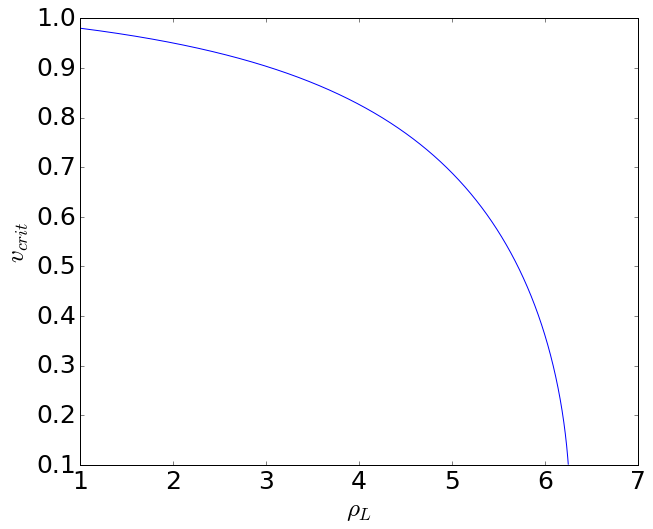

In [23]:
plt.plot(rhoLs[:len(vts)], vts)
plt.xlabel(r'$\rho_L$')
plt.ylabel(r'$v_{crit}$')

to_save = True

outfile = "../Writing/figures/vt_crit"
if to_save:
    plt.savefig(outfile)

plt.show()

In [10]:
# The point where the code blew up should give a good estimate of the value of rho_L when v_crit = 0
rhoLs[len(vts)-1]

5.86129861298613